In [46]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole
%config InlineBackend.figure_format = 'retina'

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import logging
logging.basicConfig(level=logging.INFO)

In [4]:
epoch_key = ('HPb', 7, 2)


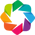

INFO:src.analysis:Detecting ripples
ERROR:loren_frank_data_processing.core:Failed to load file: /Users/edeno/Documents/GitHub/Jadhav-2016-Data-Analysis/src/../Raw-Data/HPb_direct/HPbDIO07.mat
ERROR:loren_frank_data_processing.core:Failed to load file: /Users/edeno/Documents/GitHub/Jadhav-2016-Data-Analysis/src/../Raw-Data/HPb_direct/HPbDIO07.mat


In [5]:
from src.analysis import detect_epoch_ripples
from src.parameters import (ANIMALS, SAMPLING_FREQUENCY)

ripple_times = detect_epoch_ripples(
    epoch_key, ANIMALS, SAMPLING_FREQUENCY)

In [6]:
from src.analysis import decode_ripple_clusterless

replay_info, _, _ = decode_ripple_clusterless(
    epoch_key, ANIMALS, ripple_times)

INFO:src.analysis:Decoding ripples
ERROR:loren_frank_data_processing.core:Failed to load file: /Users/edeno/Documents/GitHub/Jadhav-2016-Data-Analysis/src/../Raw-Data/HPb_direct/HPbDIO07.mat
ERROR:loren_frank_data_processing.core:Failed to load file: /Users/edeno/Documents/GitHub/Jadhav-2016-Data-Analysis/src/../Raw-Data/HPb_direct/HPbDIO07.mat
INFO:replay_classification.decoders:Fitting state transition model...
INFO:replay_classification.decoders:Fitting observation model...
INFO:src.analysis:Predicting replay types


In [7]:
replay_info.head()

ripple_number      start_time        end_time animal  day  epoch  \
0              1 00:45:47.826000 00:45:47.896000    HPb    7      2   
1              2 00:45:48.592667 00:45:48.632000    HPb    7      2   
2              3 00:45:53.024666 00:45:53.061333    HPb    7      2   
3              4 00:45:53.270000 00:45:53.332666    HPb    7      2   
4              5 00:46:02.859333 00:46:02.934666    HPb    7      2   

  ripple_duration predicted_state  predicted_state_probability   replay_task  \
0 00:00:00.070000    Unclassified                          NaN  Unclassified   
1 00:00:00.039333    Unclassified                          NaN  Unclassified   
2 00:00:00.036667    Unclassified                          NaN  Unclassified   
3 00:00:00.062666    Unclassified                          NaN  Unclassified   
4 00:00:00.075333    Unclassified                          NaN  Unclassified   

       ...       from_well to_well  task  is_correct  x_position y_position  \
0      ...             NaN     NaN   NaN         NaN       75.04  63.476757   
1      ...             NaN     NaN   NaN         NaN       75.04  63.466112   
2      ...             NaN     NaN   NaN         NaN       76.16  63.280000   
3      ...             NaN     NaN   NaN         NaN       76.16  63.280000   
4      ...             NaN     NaN   NaN         NaN       73.92  61.040000   

  head_direction     speed linear_distance  replay_motion  
0      -2.969647  0.191187             0.0        Towards  
1      -2.983522  0.203164             0.0        Towards  
2      -2.988943  0.369017             0.0        Towards  
3      -2.994514  0.775952             0.0        Towards  
4      -2.516108  0.857799             0.0        Towards  

[5 rows x 25 columns]

In [9]:
from loren_frank_data_processing import make_neuron_dataframe

neuron_info = make_neuron_dataframe(ANIMALS).xs(
    epoch_key, drop_level=False).query('numspikes > 0')

In [10]:
neuron_info.head()

area       csi  meanrate  \
animal day epoch tetrode_number neuron_number                            
HPb    7   2     1              1              CA1  0.121622  0.424938   
                                2              CA1  0.083067  0.513536   
                                3              CA1  0.121833  1.521739   
                 3              1              CA1  0.109869  1.687449   
                 4              1              CA1  0.000000  0.001641   

                                                       neuron_id  numspikes  \
animal day epoch tetrode_number neuron_number                                 
HPb    7   2     1              1              HPb_07_02_001_001      518.0   
                                2              HPb_07_02_001_002      626.0   
                                3              HPb_07_02_001_003     1855.0   
                 3              1              HPb_07_02_003_001     2057.0   
                 4              1              HPb_07_02_004_001        2.0   

                                               propbursts  spikewidth  
animal day epoch tetrode_number neuron_number                          
HPb    7   2     1              1                0.405405    9.154502  
                                2                0.269968    9.800512  
                                3                0.365499    9.839708  
                 3              1                0.326689   10.464083  
                 4              1                0.000000   10.048255

In [13]:
from loren_frank_data_processing import make_tetrode_dataframe

tetrode_info = make_tetrode_dataframe(ANIMALS).xs(epoch_key, drop_level=False)

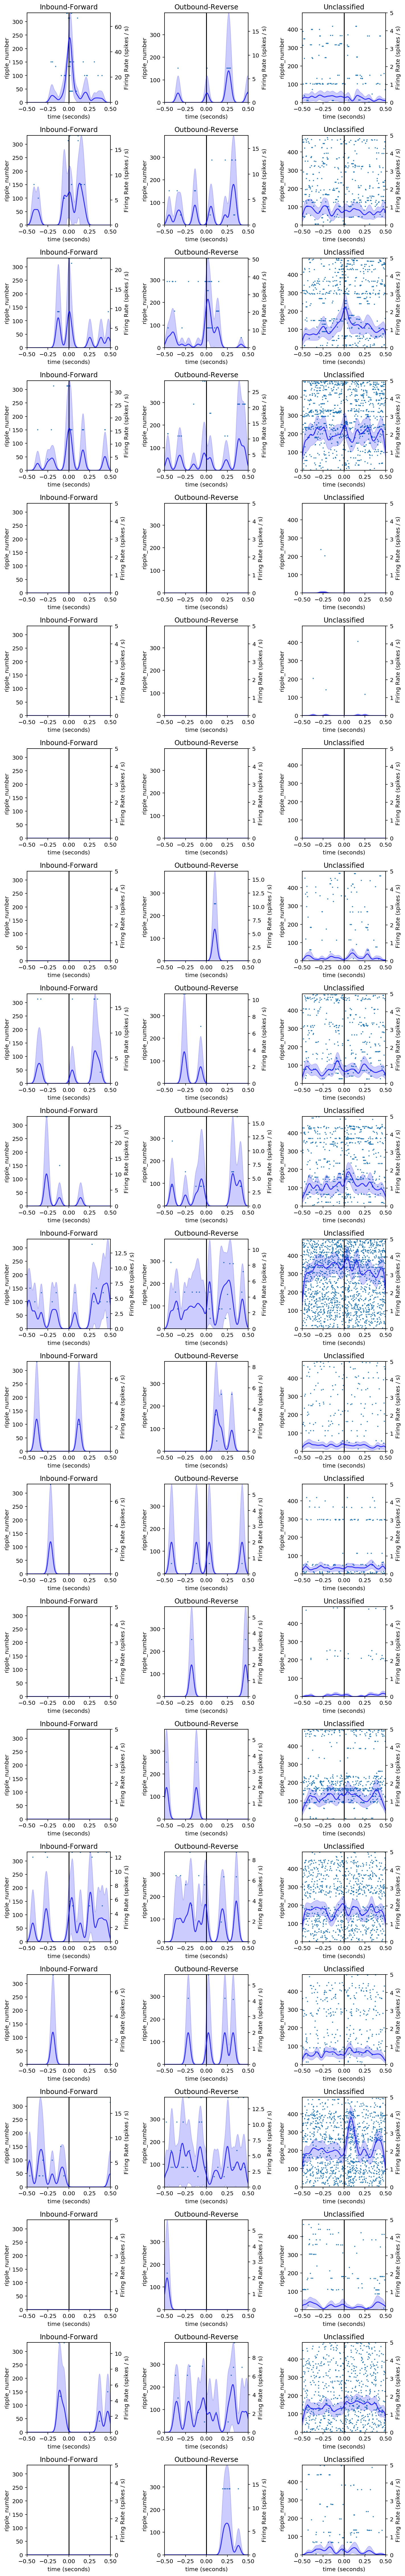

In [80]:
from src.visualization import plot_perievent_raster

n_states = len(replay_info.predicted_state.unique())
n_neurons = len(neuron_info.index)
fig, axes = plt.subplots(n_neurons, n_states, figsize=(n_states * 3, n_neurons * 3))

for neuron_key, ax_row in zip(neuron_info.index, axes):
    for ax, (name, df) in zip(ax_row, replay_info.set_index('ripple_number').groupby('predicted_state')):
        plot_perievent_raster(neuron_key, ANIMALS, df.loc[:, ['start_time', 'end_time']],
                              tetrode_info, window_offset=(-0.5, 0.5),
                              ax=ax, s=1)
        ax.set_title(name)
    
plt.tight_layout()

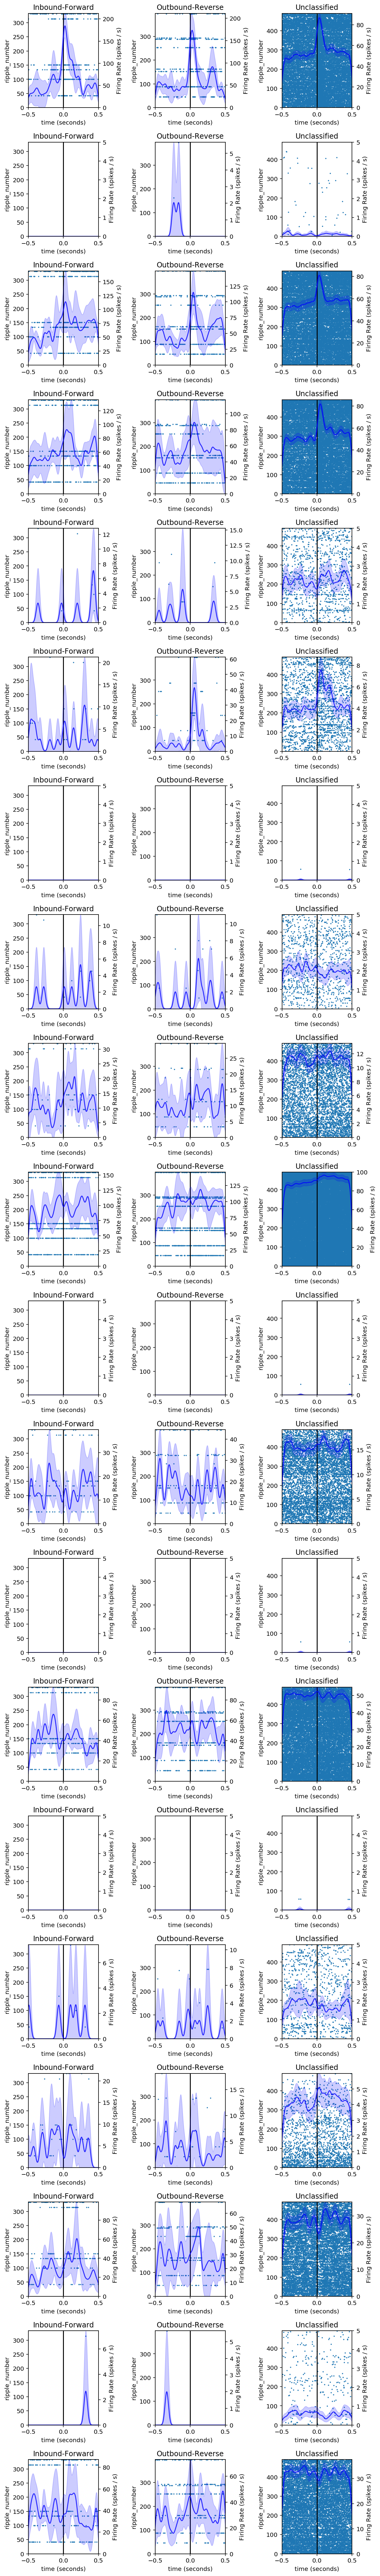

In [81]:
n_states = len(replay_info.predicted_state.unique())
n_tetrodes = len(tetrode_info.index)
fig, axes = plt.subplots(n_tetrodes, n_states, figsize=(n_states * 3, n_tetrodes * 3))

for tetrode_key, ax_row in zip(tetrode_info.index, axes):
    for ax, (name, df) in zip(ax_row, replay_info.set_index('ripple_number').groupby('predicted_state')):
        plot_perievent_raster(tetrode_key, ANIMALS, df.loc[:, ['start_time', 'end_time']],
                              tetrode_info, window_offset=(-0.5, 0.5),
                              ax=ax, s=1)
        ax.set_title(name)
    
plt.tight_layout()

In [83]:
replay_info.predicted_state.value_counts()

Unclassified        476
Outbound-Reverse      8
Inbound-Forward       6
Name: predicted_state, dtype: int64